Notes:
- Needs to run on python 3.9 ... might need to adjust the rest of the repo

In [16]:
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

import mediapy as media
import matplotlib.pyplot as plt

from datetime import datetime
import functools
from IPython.display import HTML
import jax
from jax import numpy as jp
import numpy as np
from typing import Any, Dict, Sequence, Tuple, Union

from brax import base
from brax import envs
from brax import math
from brax.base import Base, Motion, Transform
from brax.envs.base import Env, PipelineEnv, State
from brax.mjx.base import State as MjxState
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks
from brax.io import html, mjcf, model

from etils import epath
from flax import struct
from matplotlib import pyplot as plt
import mediapy as media
from ml_collections import config_dict
import mujoco
from mujoco import mjx

np.set_printoptions(precision=3, suppress=True, linewidth=100)
#%env MUJOCO_GL=egl

In [17]:
device = jax.devices("gpu")[1]

In [18]:
xml = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <body name="box_and_sphere" euler="0 0 -30">
      <joint name="swing" type="hinge" axis="1 -1 0" pos="-.2 -.2 -.2"/>
      <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
      <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
    </body>
  </worldbody>
</mujoco>
"""

In [19]:
mj_model = mujoco.MjModel.from_xml_string(xml)
mj_data = mujoco.MjData(mj_model)

In [20]:
mjx_model = mjx.put_model(mj_model, device)
mjx_data = mjx.put_data(mj_model, mj_data, device)

In [21]:
print(mj_data.qpos, type(mj_data.qpos))
print(mjx_data.qpos, type(mjx_data.qpos), mjx_data.qpos.devices())

[0.] <class 'numpy.ndarray'>
[0.] <class 'jaxlib.xla_extension.ArrayImpl'> {cuda(id=1)}


Note: skipping all things that involve rendering for now...

In [22]:
rng = jax.random.PRNGKey(0)
rng = jax.random.split(rng, 4096)
batch = jax.vmap(lambda rng: mjx_data.replace(qpos=jax.random.uniform(rng, (1,))))(rng)

jit_step = jax.jit(jax.vmap(mjx.step, in_axes=(None, 0)))
batch = jit_step(mjx_model, batch)

print(batch.qpos)

[[0.624]
 [0.089]
 [0.677]
 ...
 [0.031]
 [0.211]
 [0.808]]


In [23]:
batched_mj_data = mjx.get_data(mj_model, batch)
print([d.qpos for d in batched_mj_data])

[array([0.624]), array([0.089]), array([0.677]), array([0.172]), array([0.045]), array([0.254]), array([0.879]), array([0.838]), array([0.073]), array([0.696]), array([0.768]), array([0.451]), array([0.592]), array([0.961]), array([0.747]), array([0.708]), array([0.955]), array([0.997]), array([0.73]), array([0.85]), array([0.308]), array([0.068]), array([0.812]), array([0.993]), array([0.106]), array([0.153]), array([0.418]), array([0.439]), array([0.915]), array([0.178]), array([0.55]), array([0.913]), array([0.288]), array([0.971]), array([0.735]), array([0.406]), array([0.076]), array([0.571]), array([0.543]), array([0.536]), array([0.658]), array([0.969]), array([0.329]), array([0.726]), array([0.48]), array([0.211]), array([0.782]), array([0.52]), array([0.707]), array([0.694]), array([0.43]), array([0.518]), array([0.566]), array([0.893]), array([0.38]), array([0.634]), array([0.303]), array([0.327]), array([0.441]), array([0.326]), array([0.37]), array([0.814]), array([0.822]),

# Humanoid Env

In [24]:
#@title Humanoid Env

class Humanoid(PipelineEnv):

  def __init__(
      self,
      forward_reward_weight=1.25,
      ctrl_cost_weight=0.1,
      healthy_reward=5.0,
      terminate_when_unhealthy=True,
      healthy_z_range=(1.0, 2.0),
      reset_noise_scale=1e-2,
      exclude_current_positions_from_observation=True,
      **kwargs,
  ):
    path = epath.Path(epath.resource_path('mujoco')) / (
        'mjx/test_data/humanoid'
    )
    mj_model = mujoco.MjModel.from_xml_path(
        (path / 'humanoid.xml').as_posix())
    mj_model.opt.solver = mujoco.mjtSolver.mjSOL_CG
    mj_model.opt.iterations = 6
    mj_model.opt.ls_iterations = 6

    sys = mjcf.load_model(mj_model)

    physics_steps_per_control_step = 5
    kwargs['n_frames'] = kwargs.get(
        'n_frames', physics_steps_per_control_step)
    kwargs['backend'] = 'mjx'

    super().__init__(sys, **kwargs)

    self._forward_reward_weight = forward_reward_weight
    self._ctrl_cost_weight = ctrl_cost_weight
    self._healthy_reward = healthy_reward
    self._terminate_when_unhealthy = terminate_when_unhealthy
    self._healthy_z_range = healthy_z_range
    self._reset_noise_scale = reset_noise_scale
    self._exclude_current_positions_from_observation = (
        exclude_current_positions_from_observation
    )

  def reset(self, rng: jp.ndarray) -> State:
    """Resets the environment to an initial state."""
    rng, rng1, rng2 = jax.random.split(rng, 3)

    low, hi = -self._reset_noise_scale, self._reset_noise_scale
    qpos = self.sys.qpos0 + jax.random.uniform(
        rng1, (self.sys.nq,), minval=low, maxval=hi
    )
    qvel = jax.random.uniform(
        rng2, (self.sys.nv,), minval=low, maxval=hi
    )

    data = self.pipeline_init(qpos, qvel)

    obs = self._get_obs(data, jp.zeros(self.sys.nu))
    reward, done, zero = jp.zeros(3)
    metrics = {
        'forward_reward': zero,
        'reward_linvel': zero,
        'reward_quadctrl': zero,
        'reward_alive': zero,
        'x_position': zero,
        'y_position': zero,
        'distance_from_origin': zero,
        'x_velocity': zero,
        'y_velocity': zero,
    }
    return State(data, obs, reward, done, metrics)

  def step(self, state: State, action: jp.ndarray) -> State:
    """Runs one timestep of the environment's dynamics."""
    data0 = state.pipeline_state
    data = self.pipeline_step(data0, action)

    com_before = data0.subtree_com[1]
    com_after = data.subtree_com[1]
    velocity = (com_after - com_before) / self.dt
    forward_reward = self._forward_reward_weight * velocity[0]

    min_z, max_z = self._healthy_z_range
    is_healthy = jp.where(data.q[2] < min_z, 0.0, 1.0)
    is_healthy = jp.where(data.q[2] > max_z, 0.0, is_healthy)
    if self._terminate_when_unhealthy:
      healthy_reward = self._healthy_reward
    else:
      healthy_reward = self._healthy_reward * is_healthy

    ctrl_cost = self._ctrl_cost_weight * jp.sum(jp.square(action))

    obs = self._get_obs(data, action)
    reward = forward_reward + healthy_reward - ctrl_cost
    print(reward, forward_reward, healthy_reward, ctrl_cost)
    print(type(reward), type(forward_reward), type(healthy_reward), type(ctrl_cost))
    print(type(data))
    done = 1.0 - is_healthy if self._terminate_when_unhealthy else 0.0
    state.metrics.update(
        forward_reward=forward_reward,
        reward_linvel=forward_reward,
        reward_quadctrl=-ctrl_cost,
        reward_alive=healthy_reward,
        x_position=com_after[0],
        y_position=com_after[1],
        distance_from_origin=jp.linalg.norm(com_after),
        x_velocity=velocity[0],
        y_velocity=velocity[1],
    )

    return state.replace(
        pipeline_state=data, obs=obs, reward=reward, done=done
    )

  def _get_obs(
      self, data: mjx.Data, action: jp.ndarray
  ) -> jp.ndarray:
    """Observes humanoid body position, velocities, and angles."""
    position = data.qpos
    if self._exclude_current_positions_from_observation:
      position = position[2:]

    # external_contact_forces are excluded
    return jp.concatenate([
        position,
        data.qvel,
        data.cinert[1:].ravel(),
        data.cvel[1:].ravel(),
        data.qfrc_actuator,
    ])


envs.register_environment('humanoid', Humanoid)

In [25]:
# instantiate the environment
env_name = 'humanoid'
env = envs.get_environment(env_name)

# define the jit reset/step functions - note: optimizes function (kernal fusion and constant folding), statically-typed machine code, (in other use cases, helps with automatic differentiation...)
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

In [26]:
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

# grab a trajectory
for i in range(10):
  ctrl = -0.1 * jp.ones(env.sys.nu)
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)> 5.0 Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
<class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'> <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'> <class 'float'> <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
<class 'brax.mjx.base.State'>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)> 5.0 Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
<class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'> <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'> <class 'float'> <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
<class 'brax.mjx.base.State'>


In [64]:
def forward_reward_fn(state: base.State, action: jp.ndarray, next_state: base.State, dt: jax.Array, params: Dict[str, float]) -> jp.ndarray:
    """Reward function for moving forward.

    Args:
        state: Current state.
        action: Action taken.
        next_state: Next state.
        dt: Time step.
        params: Reward parameters.
    Returns:
        A float wrapped in a jax array. 
    """
    xpos = state.subtree_com[1][0] # TODO: include stricter typing than base.State to avoid this type error
    next_xpos = next_state.subtree_com[1][0]
    velocity = (next_xpos - xpos) / dt
    forward_reward = params['weight'] * velocity

    return forward_reward

ctrl = .1 * jp.ones(env.sys.nu)
data = state.pipeline_state
print("prev position", data.subtree_com[1][0])
next_data = jit_step(state, ctrl).pipeline_state
print("next position", next_data.subtree_com[1][0])

dt = env.dt
params = {'weight': 1.25}

forward_reward_fn(data, ctrl, next_data, dt, params)

prev position 0.026874056
next position 0.032642037


Array(0.288, dtype=float32)

In [70]:
type(state.pipeline_state)

brax.mjx.base.State

: 

In [48]:
#media.show_video(env.render(rollout, camera='side'), fps=1.0 / env.dt)
# Fix GL / media issues, probably the cause of this running forever

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=5/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=5/0)> 5.0 Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=5/0)>
<class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'> <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'> <class 'float'> <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
<class 'brax.mjx.base.State'>


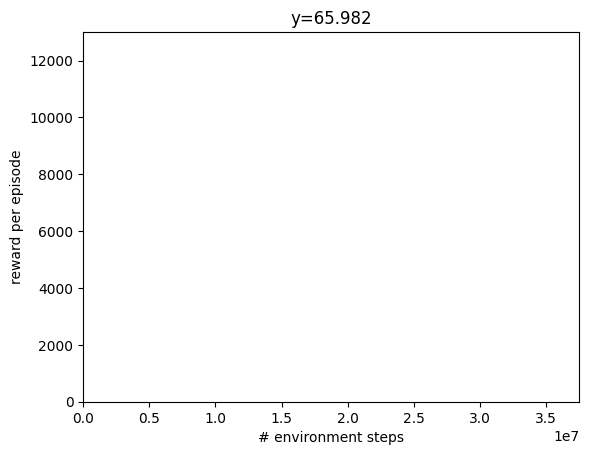

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=6/1)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=6/1)> 5.0 Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=6/1)>
<class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'> <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'> <class 'float'> <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
<class 'brax.mjx.base.State'>


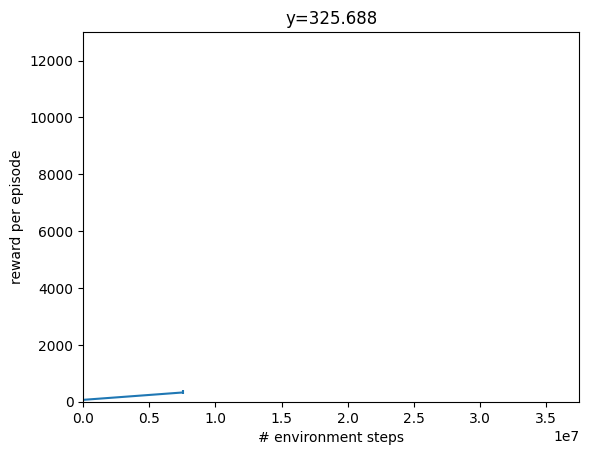

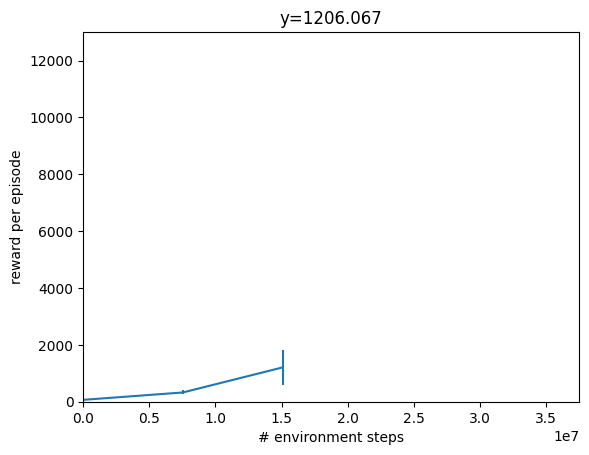

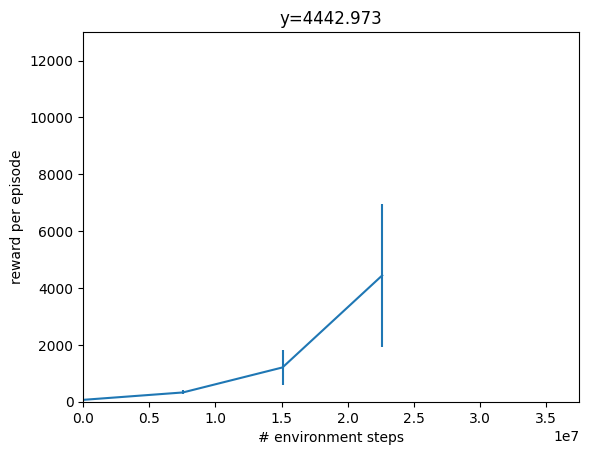

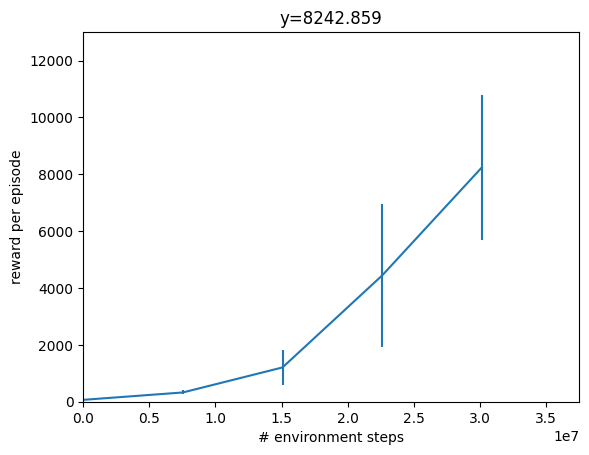

time to jit: 0:00:49.569381
time to train: 0:04:07.341922


In [29]:
train_fn = functools.partial(
    ppo.train, num_timesteps=30_000_000, num_evals=5, reward_scaling=0.1,
    episode_length=1000, normalize_observations=True, action_repeat=1,
    unroll_length=10, num_minibatches=32, num_updates_per_batch=8,
    discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048,
    batch_size=1024, seed=0)


x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]

max_y, min_y = 13000, 0
def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()

make_inference_fn, params, _= train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [30]:
model_path = '/tmp/mjx_brax_policy'
model.save_params(model_path, params)

In [31]:
#@title Load Model and Define Inference Function
params = model.load_params(model_path)

inference_fn = make_inference_fn(params)
jit_inference_fn = jax.jit(inference_fn)

# Training With Domain Randomization

In [32]:
def domain_randomize(sys, rng):
  """Randomizes the mjx.Model."""
  @jax.vmap
  def rand(rng):
    _, key = jax.random.split(rng, 2)
    # friction
    friction = jax.random.uniform(key, (1,), minval=0.6, maxval=1.4)
    friction = sys.geom_friction.at[:, 0].set(friction)
    # actuator
    _, key = jax.random.split(key, 2)
    gain_range = (-5, 5)
    param = jax.random.uniform(
        key, (1,), minval=gain_range[0], maxval=gain_range[1]
    ) + sys.actuator_gainprm[:, 0]
    gain = sys.actuator_gainprm.at[:, 0].set(param)
    bias = sys.actuator_biasprm.at[:, 1].set(-param)
    return friction, gain, bias

  friction, gain, bias = rand(rng)

  in_axes = jax.tree_util.tree_map(lambda x: None, sys)
  in_axes = in_axes.tree_replace({
      'geom_friction': 0,
      'actuator_gainprm': 0,
      'actuator_biasprm': 0,
  })

  sys = sys.tree_replace({
      'geom_friction': friction,
      'actuator_gainprm': gain,
      'actuator_biasprm': bias,
  })

  return sys, in_axes

In [33]:
rng = jax.random.PRNGKey(0)
rng = jax.random.split(rng, 10)
batched_sys, _ = domain_randomize(env.sys, rng)

print('Single env friction shape: ', env.sys.geom_friction.shape)
print('Batched env friction shape: ', batched_sys.geom_friction.shape)

print('Friction on geom 0: ', env.sys.geom_friction[0, 0])
print('Random frictions on geom 0: ', batched_sys.geom_friction[:, 0, 0])

Single env friction shape:  (20, 3)
Batched env friction shape:  (10, 20, 3)
Friction on geom 0:  1.0
Random frictions on geom 0:  [0.884 0.923 0.776 1.339 1.3   0.648 0.754 1.288 0.731 0.978]
